# Compare Valik prefiltering to Stellar ground truth

In [107]:
import matplotlib.pyplot as plt

SMALL_SIZE = 15
MEDIUM_SIZE = 17
BIGGER_SIZE = 20

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=MEDIUM_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize

plt.rcParams["figure.figsize"] = (9,6)

## Experiment setup

Simulated two sequence experiments:
- both 83^6 bytes in size 
- read length 150
- reads sampled with 0.05 error rate
- 64 bins
    - 10Mb reference genome or 80Mb reference genome
    - 512 or 64 total genomes

Local search strategies:
- minLen 50
- max error rate: 0.025 or 1 error
- (15, 13)-minimisers
- overlap (1-49)

In [101]:
#---------- INPUT ----------
sim_er = 0.05
search_er = 0.025
o = 49

bins = 64
bin_list = list(range(bins))
bin_list = [str(bin).zfill(len(str(bins))) for bin in bin_list]

In [102]:
import pandas as pd
import numpy as np

# input: path to stellar output
# output: df where instead of specific sequences reads are mapped to a bin
def get_stellar_bin_df(stellar_path):
    stellar_bin_df = pd.read_csv(stellar_path, sep=" ", header=None)
    stellar_bin_df.columns = ["Stellar-BIN", "QID"]
    stellar_bin_df["Stellar-BIN"] = pd.to_numeric(stellar_bin_df["Stellar-BIN"].str.split("_").str[1])
    stellar_bin_df = stellar_bin_df[["QID", "Stellar-BIN"]].drop_duplicates()
    return stellar_bin_df

def get_stellar_df():
    frames = []
    for b in bin_list:
        stellar_path = stellar_path = "../out/matches/bin_" + b + "_e" + str(sim_er) + ".txt"
        stellar_bin_df = get_stellar_bin_df(stellar_path)
        frames.append(stellar_bin_df)

    stellar_df = pd.concat(frames, ignore_index = True)
    stellar_df = stellar_df.drop_duplicates()
    return stellar_df

def get_valik_df(valik_path):
    valik_df = pd.read_csv(valik_path, sep="\t", header=None)
    valik_df.columns = ["QID", "matches"]
    valik_df = valik_df.assign(match_cols=valik_df['matches'].str.split(',')).explode('matches')
    valik_df = valik_df.drop(["matches"], axis = 1)
    valik_df = valik_df.explode("match_cols")
    valik_df.columns = ["QID", "Valik-BIN"]
    valik_df = valik_df.replace(r'^\s*$', np.nan, regex=True).dropna() # drop empty rows
    valik_df = valik_df.reset_index(drop = True)
    valik_df["Valik-BIN"] = pd.to_numeric(valik_df["Valik-BIN"])
    return valik_df

## Prefiltering performance depending on IBF size

In [103]:
stellar_df = get_stellar_df()

import os.path

size_list = ["1M", "5M", "10M", "15M", "20M", "25M", "30M", "35M", "40M", "45M", "50M", "55M", "60M"]
with open('../search_accuracy.tsv', 'a') as f:
    f.write("IBF-size\tTP\tFP\tFN\tPrecision\tRecall\n")
    for size in size_list:
        valik_path = "../out/" + size + "/e" + str(sim_er) + "_o" + str(o) + ".out"
        valik_df = get_valik_df(valik_path)
        
        TP_df = pd.merge(valik_df, stellar_df,  how='inner', left_on=["QID","Valik-BIN"], right_on = ["QID","Stellar-BIN"])
        TP = len(TP_df["QID"])
        
        # number of unnecessary bins that need to be searched
        FP = len(valik_df["QID"]) - TP
        
        # number of bin matches that can not be found after prefiltering
        FN = len(stellar_df["QID"]) - TP
        
        precision = TP / (TP + FP)
        
        recall = TP / (TP + FN)
        
        f.write(size + "\t" + str(TP) + "\t" + str(FP) + "\t" + str(FN) + "\t" + str(precision) 
                + "\t" + str(recall) + "\n")

        print("Finished processing {}".format(size))
f.close()

Finished processing 1M
Finished processing 5M
Finished processing 10M
Finished processing 15M
Finished processing 20M
Finished processing 25M
Finished processing 30M
Finished processing 35M
Finished processing 40M
Finished processing 45M
Finished processing 50M
Finished processing 55M
Finished processing 60M


In [109]:
res8 = pd.read_csv("../8_haplotypes_search_accuracy.tsv", sep="\t")
res8

,IBF-size,TP,FP,FN,Precision,Recall
0,1M,460550,29446302,8,0.015399,0.999983
1,5M,459076,46093,1482,0.908757,0.996782
2,10M,458693,44065,1865,0.912353,0.995951
3,15M,458598,43629,1960,0.913129,0.995744
4,20M,458558,43515,2000,0.913329,0.995657
5,25M,458531,43408,2027,0.913519,0.995599
6,30M,458524,43380,2034,0.913569,0.995584
7,35M,458512,43348,2046,0.913625,0.995558
8,40M,458512,43323,2046,0.913671,0.995558
9,45M,458507,43317,2051,0.913681,0.995547


In [110]:
res1 = pd.read_csv("../1_haplotype_search_accuracy.tsv", sep="\t")
res1

,IBF-size,TP,FP,FN,Precision,Recall
0,1M,460555,32307381,1,0.014055,0.999998
1,5M,460555,32307202,1,0.014055,0.999998
2,10M,460527,19187650,29,0.023439,0.999937
3,15M,460309,2603779,247,0.150227,0.999464
4,20M,460054,426686,502,0.518815,0.998910
5,25M,459829,132159,727,0.776754,0.998421
6,30M,459621,74240,935,0.860938,0.997970
7,35M,459495,58113,1061,0.887728,0.997696
8,40M,459376,52420,1180,0.897576,0.997438
9,45M,459319,49802,1237,0.902180,0.997314


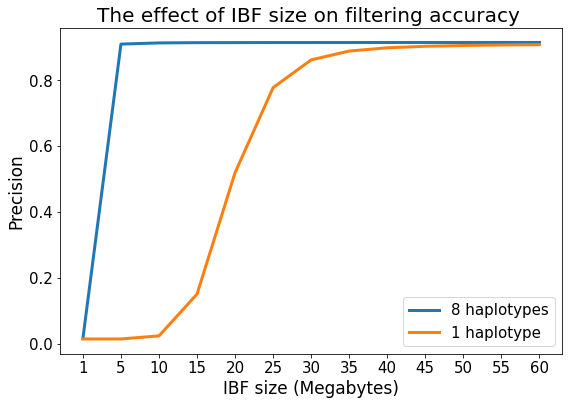

In [125]:
X = [s.replace("M", "") for s in size_list]

h8 = res8["Precision"]
h1 = res1["Precision"]
plt.plot(X, h8, label = "8 haplotypes", linewidth=3)
plt.plot(X, h1, label = "1 haplotype", linewidth=3)

plt.title('The effect of IBF size on filtering accuracy ', size = 20)
plt.xlabel('IBF size (Megabytes)')
plt.ylabel('Precision')
plt.legend()
#plt.xlim([0.01, 0.07])
plt.savefig("../IBF_size.png", dpi = 140)
plt.show()

In [120]:
size_list

['0M',
 '5M',
 '10M',
 '15M',
 '20M',
 '25M',
 '30M',
 '35M',
 '40M',
 '45M',
 '50M',
 '55M',
 '60M']

## Prefiltering preformance depending on overlap

## Compare different search strategies

In [4]:
import pandas as pd
import numpy as np
res = pd.read_csv("mapping_results.txt", sep="\t", header = None, dtype=int)
res.columns = ["rer", "p", "e", "k", "o", "TP", "TP+FP", "T"]
res

,rer,p,e,k,o,TP,TP+FP,T
0,3,30,0,23,0,1024,1024,1024
1,3,30,0,23,10,1024,1024,1024
2,3,30,1,13,0,1024,5305,1024
3,3,30,1,13,10,1024,6887,1024
4,3,30,1,15,0,1024,61687,1024
...,...,...,...,...,...,...,...,...
243,10,50,1,23,49,731,2738,731
244,10,50,2,15,0,1015,1426,1015
245,10,50,2,15,10,1015,1514,1015
246,10,50,2,15,40,1015,1992,1015


In [5]:
res['FPr'] = res.apply(lambda row: (row["TP+FP"] - row["TP"]) / row["TP+FP"], axis=1)
res = res.fillna(0)
res['FNr'] = res.apply(lambda row: (row["T"] - row["TP"]) / row["T"], axis=1)
res.head()

/home/evelin/.local/lib/python3.7/site-packages/ipykernel_launcher.py:1: RuntimeWarning: invalid value encountered in long_scalars
  """Entry point for launching an IPython kernel.


,rer,p,e,k,o,TP,TP+FP,T,FPr,FNr
0,3,30,0,23,0,1024,1024,1024,0.000000,0.0
1,3,30,0,23,10,1024,1024,1024,0.000000,0.0
2,3,30,1,13,0,1024,5305,1024,0.806975,0.0
3,3,30,1,13,10,1024,6887,1024,0.851314,0.0
4,3,30,1,15,0,1024,61687,1024,0.983400,0.0


In [6]:
res["kmer_lemma"] = res.apply(lambda row: int(row["p"] - (row["e"] + 1)*row["k"] + 1), axis = 1)
res.head()

,rer,p,e,k,o,TP,TP+FP,T,FPr,FNr,kmer_lemma
0,3,30,0,23,0,1024,1024,1024,0.000000,0.0,8
1,3,30,0,23,10,1024,1024,1024,0.000000,0.0,8
2,3,30,1,13,0,1024,5305,1024,0.806975,0.0,5
3,3,30,1,13,10,1024,6887,1024,0.851314,0.0,5
4,3,30,1,15,0,1024,61687,1024,0.983400,0.0,1


### k-mer length

I quickly found that I can't define the local match to be of length 30 with 2 errors because the k-mer length would have to be 9 or 10 and there are enough spurious matches for such short k-mers. But STELLAR can handle this query.

Depending on the error rate and minLen I still found reasonable results starting from 13-mers.

In [7]:
def probability(k):
    # each bin is 1MB which accounts for 
    bits = 1024 * 1024 * 8

    prob = bits / 4**k / 2
    print("by chance you would find any " + str(k) + "-mer " + str(prob) + " times in each bin")
    

for k in [9, 13, 15, 24]:
    probability(k)

by chance you would find any 9-mer 16.0 times in each bin
by chance you would find any 13-mer 0.0625 times in each bin
by chance you would find any 15-mer 0.00390625 times in each bin
by chance you would find any 24-mer 1.4901161193847656e-08 times in each bin


In [8]:
res[res["TP+FP"] == res["TP+FP"].max()].head()

,rer,p,e,k,o,TP,TP+FP,T,FPr,FNr,kmer_lemma
83,7,30,1,15,10,1024,64284,1024,0.984071,0.0,1


In [9]:
np.unique(res[res["TP+FP"] == res["TP+FP"].max()]["k"])

array([15])

9-mers are found spuriously and result in many false positives. All bins are hit

In [10]:
np.unique(res[res.k == 9]["TP+FP"])

array([], dtype=int64)

In [11]:
#res = res[res["k"] != 9]
res

,rer,p,e,k,o,TP,TP+FP,T,FPr,FNr,kmer_lemma
0,3,30,0,23,0,1024,1024,1024,0.000000,0.0,8
1,3,30,0,23,10,1024,1024,1024,0.000000,0.0,8
2,3,30,1,13,0,1024,5305,1024,0.806975,0.0,5
3,3,30,1,13,10,1024,6887,1024,0.851314,0.0,5
4,3,30,1,15,0,1024,61687,1024,0.983400,0.0,1
...,...,...,...,...,...,...,...,...,...,...,...
243,10,50,1,23,49,731,2738,731,0.733017,0.0,5
244,10,50,2,15,0,1015,1426,1015,0.288219,0.0,6
245,10,50,2,15,10,1015,1514,1015,0.329590,0.0,6
246,10,50,2,15,40,1015,1992,1015,0.490462,0.0,6


In [12]:
np.mean(res[res.k == 13]["FPr"])

0.2604490298661108

In [13]:
np.mean(res[res.k == 15]["FPr"])

0.26876419098516385

In [14]:
np.mean(res[res.k == 23]["FPr"])

0.2751339904607605

In [15]:
np.mean(res[res.k == 13]["FNr"])

0.09546479235754368

In [16]:
np.mean(res[res.k == 15]["FNr"])

0.045571192163959204

In [17]:
np.mean(res[res.k == 23]["FNr"])

0.1576971777275363

Hard to make conclusions about k-mer length because the higher bound of the value is determined by minLen and maxErrors but I also went lower

### This just worked nicely?

In [18]:
rer5 = res[res.rer == 3]
groups = rer5.groupby(['p', 'e']).agg(['mean'])
groups.columns = groups.columns.map('_'.join)

groups[["FPr_mean", "FNr_mean", "kmer_lemma_mean"]]

FPr_mean  FNr_mean  kmer_lemma_mean
p  e                                     
30 0  0.000000  0.000000         8.000000
   1  0.906440  0.000000         3.000000
50 0  0.000410  0.093980        29.454545
   1  0.141945  0.000000        14.400000
   2  0.397861  0.000000         6.000000
70 0  0.000000  0.247961        48.000000
   1  0.000000  0.000000        37.000000
   2  0.490447  0.000000        14.000000

In [19]:
groups["FNr_mean"].values

array([0.        , 0.        , 0.09397972, 0.        , 0.        ,
       0.24796085, 0.        , 0.        ])

### Lowest number of bins found

In [20]:
res[res.TP == res.TP.min()]

,rer,p,e,k,o,TP,TP+FP,T,FPr,FNr,kmer_lemma
216,7,50,1,19,49,0,0,994,0.0,1.0,13
228,10,50,0,19,49,0,0,227,0.0,1.0,32


In [21]:
res[res.FNr == res.FNr.max()]

,rer,p,e,k,o,TP,TP+FP,T,FPr,FNr,kmer_lemma
216,7,50,1,19,49,0,0,994,0.0,1.0,13
228,10,50,0,19,49,0,0,227,0.0,1.0,32


Result matches expectations: kmer lemma threshold is high and the reads were generated with a high error rate.

In [22]:
res[(res['p'] == 70) & (res['rer'] == 10)].head()

,rer,p,e,k,o,TP,TP+FP,T,FPr,FNr,kmer_lemma
138,10,70,0,23,0,7,7,25,0.000000,0.720000,48
139,10,70,0,23,20,10,10,25,0.000000,0.600000,48
140,10,70,0,23,60,19,19,25,0.000000,0.240000,48
141,10,70,1,13,0,83,111,186,0.252252,0.553763,45
142,10,70,1,13,20,108,137,186,0.211679,0.419355,45


### How does read (sequencing) error rate influence accuracy?

In [23]:
import matplotlib.pyplot as plt

SMALL_SIZE = 15
MEDIUM_SIZE = 17
BIGGER_SIZE = 20

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=MEDIUM_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize

plt.rcParams["figure.figsize"] = (9,6)

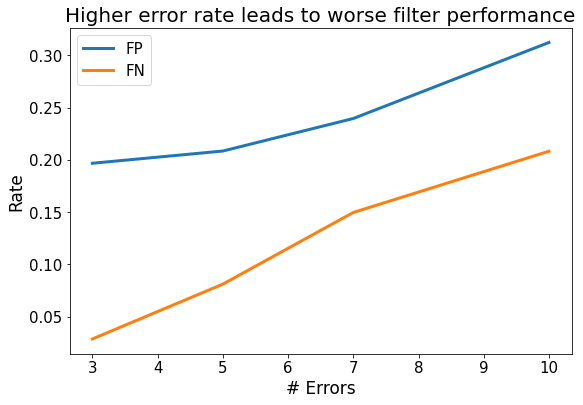

In [38]:
X = [3/150, 5/150, 7/150, 10/150]
X = [3, 5, 7, 10]
FPr = [np.mean(res[res.rer == 3]["FPr"]), np.mean(res[res.rer == 5]["FPr"]), np.mean(res[res.rer == 7]["FPr"]), np.mean(res[res.rer == 10]["FPr"])]
FNr = [np.mean(res[res.rer == 3]["FNr"]), np.mean(res[res.rer == 5]["FNr"]), np.mean(res[res.rer == 7]["FNr"]), np.mean(res[res.rer == 10]["FNr"])]
  
plt.plot(X, FPr, label = "FP", linewidth=3)
plt.plot(X, FNr, label = "FN", linewidth=3)

plt.title('Higher error rate leads to worse filter performance', size = 20)
plt.xlabel('# Errors')
plt.ylabel('Rate')
plt.legend()
#plt.xlim([0.01, 0.07])
plt.savefig("rer.png", dpi = 140)
plt.show()

In [43]:
res[(res["rer"]==5) & (res["p"]==70)]

,rer,p,e,k,o,TP,TP+FP,T,FPr,FNr,kmer_lemma
60,5,70,0,23,0,123,123,259,0.000000,0.525097,48
61,5,70,0,23,20,137,137,259,0.000000,0.471042,48
62,5,70,0,23,60,219,219,259,0.000000,0.154440,48
63,5,70,1,13,0,648,686,840,0.055394,0.228571,45
64,5,70,1,13,20,717,757,840,0.052840,0.146429,45
65,5,70,1,13,60,805,850,840,0.052941,0.041667,45
66,5,70,1,15,0,645,684,840,0.057018,0.232143,41
67,5,70,1,15,20,720,762,840,0.055118,0.142857,41
68,5,70,1,15,60,808,854,840,0.053864,0.038095,41
69,5,70,1,23,0,711,810,840,0.122222,0.153571,25


If reads were sampled from simulated genome at a higher error rate then the sliding window approach won't be able to detect STELLAR matches.

### How does overlap length influence accuracy?

In [25]:
p30 = res[(res['p'] == 30)]
p50 = res[(res['p'] == 50)]
p70 = res[(res['p'] == 70)]

In [26]:
p50 = p50.drop_duplicates()
p50 = p50.drop(p50[(p50.e == 0) & (p50.k != 23)].index)
p50 = p50.drop(p50[(p50.e == 1) & (p50.k != 15)].index)
p50 = p50.drop(p50[(p50.e == 2) & (p50.k != 15)].index)

In [27]:
groups = p50.groupby('o').agg(['mean'])
groups.columns = groups.columns.map('_'.join)
groups

,rer_mean,p_mean,e_mean,k_mean,TP_mean,TP+FP_mean,T_mean,FPr_mean,FNr_mean,kmer_lemma_mean
o,,,,,,,,,,
0,6.25,50,1,17.666667,756.000000,895.416667,857.333333,0.105955,0.186872,18.333333
10,6.25,50,1,17.666667,777.916667,958.000000,857.333333,0.125216,0.150857,18.333333
40,6.25,50,1,17.666667,834.166667,1173.750000,857.333333,0.178405,0.048318,18.333333
49,6.25,50,1,19.000000,814.375000,1523.750000,814.375000,0.292560,0.000000,17.000000


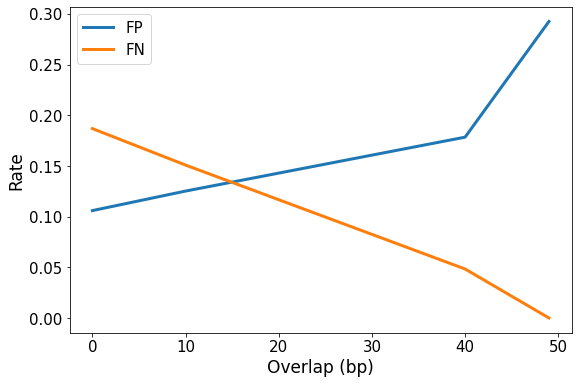

In [28]:
import matplotlib.pyplot as plt

X = [0, 10, 40, 49]
FPr = groups["FPr_mean"]
FNr = groups["FNr_mean"]

plt.plot(X, FPr, label = "FP", linewidth = 3)
plt.plot(X, FNr, label = "FN", linewidth = 3)

#plt.title('Local matches of length 70bp')
plt.xlabel('Overlap (bp)')
plt.ylabel('Rate')
plt.legend()
plt.savefig("p50_o.png", dpi = 120)
plt.show()

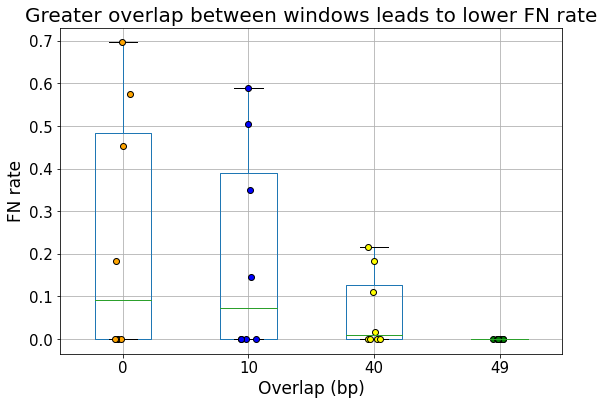

In [29]:
data = pd.DataFrame({ "0":p50[(p50["o"]==0) & (p50["e"]!=1)]["FNr"].values,
                      "10":p50[(p50["o"]==10) & (p50["e"]!=1)]["FNr"].values, 
                      "40":p50[(p50["o"]==40) & (p50["e"]!=1)]["FNr"].values,
                       "49":p50[(p50["o"]==49) & (p50["e"]!=1)]["FNr"].values})

data.boxplot()

for i,d in enumerate(data):
    y = data[d]
    x = np.random.normal(i+1, 0.04, len(y))
    plt.xlabel("Overlap (bp)")
    plt.ylabel("FN rate")
    plt.title('Greater overlap between windows leads to lower FN rate', size = 20)
    plt.plot(x, y, mfc = ["orange","blue","yellow","green"][i], mec='k', marker="o", linestyle="None")
    plt.savefig("p50_o_box.png", dpi = 120)

In [30]:
p50[(p50["o"]==0) & (p50["rer"]==5)]

,rer,p,e,k,o,TP,TP+FP,T,FPr,FNr,kmer_lemma
45,5,50,0,23,0,400,401,731,0.002494,0.452804,28
51,5,50,1,15,0,1024,1024,1024,0.000000,0.000000,21
57,5,50,2,15,0,1024,1404,1024,0.270655,0.000000,6


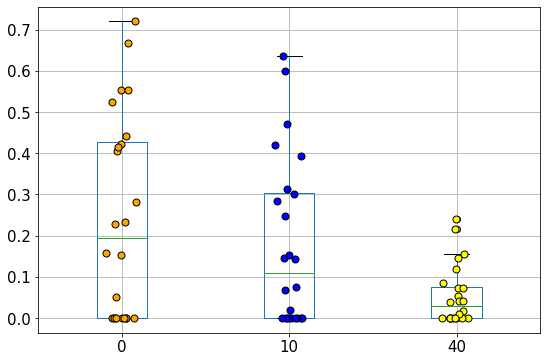

In [31]:
data = pd.DataFrame({ "0":p70[p70["o"]==0]["FNr"].values,
                      "10":p70[p70["o"]==20]["FNr"].values, 
                      "40":p70[p70["o"]==60]["FNr"].values} )

data.boxplot()

for i,d in enumerate(data):
    y = data[d]
    x = np.random.normal(i+1, 0.04, len(y))
    plt.plot(x, y, mfc = ["orange","blue","yellow"][i], mec='k', ms=7, marker="o", linestyle="None")


In [32]:
#p70 = p70.drop(p70[(p70.e == 0) & (p70.k != 23)].index)
#p70 = p70.drop(p70[(p70.e == 1) & (p70.k != 23)].index)
#p70 = p70.drop(p70[(p70.e == 2) & (p70.k != 15)].index)

In [33]:
groups = p70.groupby('o').agg(['mean'])
groups.columns = groups.columns.map('_'.join)
groups

,rer_mean,p_mean,e_mean,k_mean,TP_mean,TP+FP_mean,T_mean,FPr_mean,FNr_mean,kmer_lemma_mean
o,,,,,,,,,,
0,6.25,70,1.166667,18.666667,570.500000,8900.208333,652.041667,0.262470,0.242017,31.166667
20,6.25,70,1.166667,18.666667,597.458333,9493.750000,652.041667,0.254056,0.177987,31.166667
60,6.25,70,1.166667,18.666667,637.541667,10008.166667,652.041667,0.255621,0.054612,31.166667


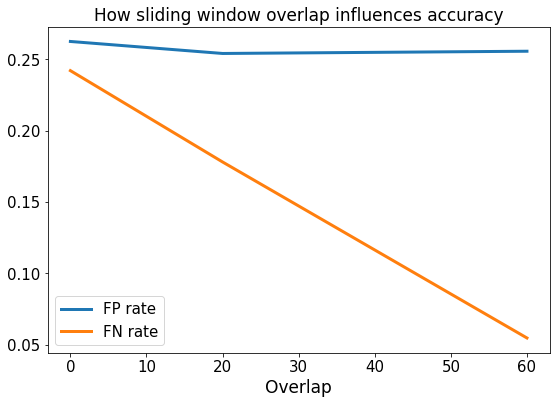

In [34]:
X = [0, 20, 60]
FPr = groups["FPr_mean"]
FNr = groups["FNr_mean"]

plt.plot(X, FPr, label = "FP rate", linewidth = 3)
plt.plot(X, FNr, label = "FN rate", linewidth = 3)

plt.title('How sliding window overlap influences accuracy')
plt.xlabel('Overlap')
plt.legend()
plt.savefig("p70_o.png", dpi = 120)
plt.show()

In [35]:
ran_raptor = pd.read_csv("64/output_e3/bin_33_k9_p30_o0_e2.output", sep="\t", header=None)
ran_raptor.columns = ["read ID", "bins"]
ran_raptor.reset_index()
ran_raptor[9:18]

,read ID,bins
9,33801,"0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18..."
10,33802,"0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18..."
11,33803,"0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18..."
12,33804,"0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18..."
13,33805,"0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18..."
14,33806,"0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18..."
15,33807,"0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18..."
16,33808,"0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18..."
17,33809,"0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18..."


In [37]:
res[(res["e"]==1) & (res["p"]==50) & (res["rer"]==7) & (res["k"]==15)]

,rer,p,e,k,o,TP,TP+FP,T,FPr,FNr,kmer_lemma
90,7,50,1,15,0,919,933,994,0.015005,0.075453,21
91,7,50,1,15,10,952,968,994,0.016529,0.042254,21
92,7,50,1,15,40,986,1003,994,0.016949,0.008048,21
210,7,50,1,15,0,919,933,994,0.015005,0.075453,21
211,7,50,1,15,10,952,968,994,0.016529,0.042254,21
212,7,50,1,15,40,986,1003,994,0.016949,0.008048,21
